<a href="https://colab.research.google.com/github/inetolko2b-svg/shine_light_on_dyes/blob/main/HOMO_LUMO_for_polyenes_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Calculating HOMO-LUMO gaps for conjugated systems!**
In this section, we’re going to get some numerical estimates for the HOMO–LUMO gaps of conjugated systems. These numbers are mainly useful for comparing different molecules — they won’t be accurate enough to predict the exact colors of the molecules (for that, see …).

We’ll take things one step further by using some ready‑made functions that can solve quantum chemical equations for us. These tools will give us numerical values for the energies of the molecular orbitals in a given molecule. We won’t dive into where these equations come from or exactly how they’re solved — instead, we’ll focus on how to use them to get meaningful and useful information about our molecules.

Below is the first code snippet that we need to run to begin our calculations. To execute the code, simply click the **Run** button and wait. This step should only take a short time. We start by installing the required packages and importing the necessary definitions. Packages are collections of Python files that contain useful pieces of code. Installing and importing them allows us to use many predefined functions without having to write the code from scratch. Note! the packages are not installed on your local computer. Instead,
Google Colab runs on a remote virtual machine. When you install a package using you are installing it on that virtual machine, not on your own computer. The installed packages will only exist for the duration of your session. Once the session ends (e.g., due to inactivity or manual reset), you'll need to reinstall them the next time you open the notebook. Once the code is executed the resutl will appear in the output window.!!!!!!!

In [ ]:
! pip install rdkit
! pip install pyscf
! pip install geometric

# import these definitions
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.drawOptions.addAtomIndices = True

# import the package
from pyscf import gto, scf, dft, tddft
from pyscf.geomopt.geometric_solver import optimize
import scipy.constants as cst
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.3/36.3 MB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.2/51.2 MB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.0/386.0 kB 24.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for geometric: filename=geometric-1.1-py3-none-any.whl size=402087 sha256=ae52551fdc6371a4842a6764ac92578c2a24b5f92d91c93be6d315c997a232c8
  Stored in directory: /root/.cache/pip/wheels/c5/77/0c/96a54539fe0560749fdbe283f92582d09bddb212856407a4cb
Successfully built geometric


Now we need to generate the desired molecule. The easiest way to do this is by using SMILES (Simplified Molecular Input Line Entry System). Every molecule can be represented as a string of symbols containing information about the types of atoms in the molecule and their connectivity. However, SMILES does not contain information about the three‑dimensional geometry of the molecule.

For common molecules, it is usually easy to find their SMILES representation online. For example, you can find the SMILES of a desired molecule in PubChem (https://pubchem.ncbi.nlm.nih.gov/) by searching for it by name or drawing its structure.

In the code below, we convert the SMILES format into an XYZ file, which contains the 3D coordinates of each atom. An XYZ file is simply a table listing the x, y, and z coordinates for each atom in the molecule. This file will appear under the Files icon on the left in Google Colab and can be downloaded and opened in various specialized molecular visualization programs — for example, in Avogadro, a free, open‑source molecular editor available at https://avogadro.cc/downloads/.

The code below reads SMILES and convert use this information to build a random 3D structure, where the angles and bond lengths are rnadom and not optimized, every time you run the cell you will generate a new conformation.

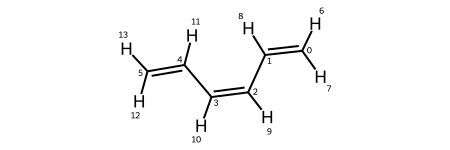

In [ ]:
# import these definitions
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.drawOptions.addAtomIndices = True

# generate the moleucle
smiles = r"C=CC=CC=C" # insert smiles for your molecule
mol = Chem.MolFromSmiles(smiles)
#Add hydrogen atoms to the molecule
mol = Chem.AddHs(mol)
#Generate a random 3D configuration
Chem.AllChem.EmbedMolecule(mol)
#Safe the molecule in XYZ file under desired name
Chem.MolToXYZFile(mol, "1,3,5-HEXATRIENE.xyz")
mol

The next cell is not necessary for our purpose, but can be interesting because for those who want to learn how to do some simple manipulations with the molecule we have generated. For example, we can change the angles. In the cell below, you can see how to do this and how it changes the structure of the molecule.

We will use the function Chem.rdMolTransforms.SetDihedralDeg(mol.GetConformer(0), a, b, c, d, angle) where you input the numbers of the atoms between which you want to set the dihedral angle, and the angle itself. In the example below, we preset the angle between atoms 1, 2, 3, and 4 to 180 degrees. You can try creating various structures by changing these values.

It is important to understand that each of these structures will have a different energy. Generally, compounds with a dihedral angle around a double bond of about 180 degrees are more stable. You can experiment and try this for your particular compound.

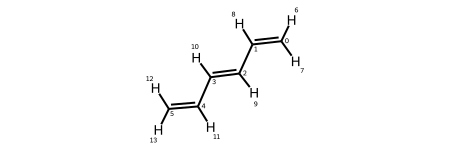

In [57]:
#set dihedral angle between atoms 1,2,3,4 to 0
Chem.AllChem.SetDihedralDeg(mol.GetConformer(0),1,2,3,4,180)
#Safe the molecule in XYZ file
Chem.MolToXYZFile(mol, "1,3,5-HEXATRIENE.xyz")
mol


So now we have generated a molecule with a rather random strcutre (even though we have seen how we can change the angels). The strcutre is still not optimal, exat bond angles and lengths are not perfect and do not correspond to the real molecule. Now we will use this not optimized strcutre to allow python to do some calculations to tune the angles and the bonds between the atoms to make it closer to the real one. We will opmit here the details of how this function works. We will just say that it changes the coordinatates of the atoms and look at the energy of the system, predicts how they should be changed to lower the energy, changes them, calulates the energy again. This process continuese all over again and again untill the energy almost stops to change.

As with all calculations there is always a trade off between the time and the accuracy. The more precision we want the longer the calculation will take. Here we opt for a rather fast method, which will be good for our purpose (to see the difference between HOMO-LUMO gaps in conjugated suystems), but will not be enough to predict real properties with high accuracy.

In [ ]:
from pyscf import gto, scf, dft, tddft

# create the pyscf molecule
mol = gto.Mole()
mol.atom="1,3,5-HEXATRIENE.xyz"# put the name of xyz file for your molecule
# set basis set
mol.basis = "sto-3g"
mol.build()

# set the functional
mf = mol.KS()
mf.xc = 'b3lyp'

# run optimatization  calculations
mol_eq = optimize(mf)

#save the optimizaed molecule
mol_eq.tofile("opt_ethylene.xyz")#put a name of the file to save your optimized structure

geometric-optimize called with the following command line:
/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py -f /root/.local/share/jupyter/runtime/kernel-a087d6d2-6775-4093-9370-ee4b8c8be8d9.json

                                        ())))))))))))))))/                     
                                    ())))))))))))))))))))))))),                
                                *)))))))))))))))))))))))))))))))))             
                        #,    ()))))))))/                .)))))))))),          
                      #%%%%,  ())))))                        .))))))))*        
                      *%%%%%%,  ))              ..              ,))))))).      
                        *%%%%%%,         ***************/.        .)))))))     
                #%%/      (%%%%%%,    /*********************.       )))))))    
              .%%%%%%#      *%%%%%%,  *******/,     **********,      .))))))   
                .%%%%%%/      *%%%%%%,  **              ********    


Geometry optimization cycle 1


/usr/local/lib/python3.11/dist-packages/pyscf/dft/libxc.py:511: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, corresponding to the original definition by Stephens et al. (issue 1480) and the same as the B3LYP functional in Gaussian. To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   C  -0.507901  -0.352986   0.239323    0.000000  0.000000  0.000000
   C   0.497870   0.380491  -0.240705    0.000000  0.000000  0.000000
   H  -0.317622  -1.415163   0.361052    0.000000  0.000000  0.000000
   H  -1.472704   0.073120   0.499874    0.000000  0.000000  0.000000
   H   1.419826  -0.135383  -0.470431    0.000000  0.000000  0.000000
   H   0.380531   1.449921  -0.389113    0.000000  0.000000  0.000000
converged SCF energy = -77.619634712641
--------------- RKS_Scanner gradients ---------------
         x                y                z
0 C    -0.0153705113    -0.0054996950     0.0063312116
1 C     0.0202192392     0.0069658956    -0.0082805784
2 H     0.0096198511     0.0102131141    -0.0051570720
3 H     0.0080091154     0.0011298571    -0.0029881881
4 H    -0.0153411794    -0.0044870208     0.0061365965
5 H    -0.0071370111    -0.0083225170     0.0039578458
--------------

Step    0 : Gradient = 1.612e-02/2.293e-02 (rms/max) Energy = -77.6196347126
Hessian Eigenvalues: 2.30000e-02 2.78828e-02 2.80809e-02 ... 3.52872e-01 3.58548e-01 5.85332e-01



Geometry optimization cycle 2
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   C  -0.482906  -0.392429   0.237583    0.024995 -0.039443 -0.001740
   C   0.517082   0.356611  -0.243142    0.019212 -0.023880 -0.002437
   H  -0.464085  -1.473813   0.422400   -0.146463 -0.058650  0.061348
   H  -1.433878   0.093790   0.482668    0.038826  0.020670 -0.017206
   H   1.509558  -0.016491  -0.522686    0.089732  0.118892 -0.052255
   H   0.354244   1.432342  -0.376817   -0.026287 -0.017579  0.012296
converged SCF energy = -77.6213283262539
--------------- RKS_Scanner gradients ---------------
         x                y                z
0 C    -0.0013848689    -0.0067486681     0.0016812605
1 C     0.0070999331     0.0045012892    -0.0032734261
2 H    -0.0062237666    -0.0001882853     0.0022007820
3 H     0.0024060741     0.0007866560    -0.0009763258
4 H     0.0007483090     0.0030592521    -0.0008023276
5 H    -0.0026460967    -0.0014091950

Step    1 : Displace = 1.001e-01/1.693e-01 (rms/max) Trust = 1.000e-01 (=) Grad = 5.825e-03/9.021e-03 (rms/max) E (change) = -77.6213283263 (-1.694e-03) Quality = 0.352
Hessian Eigenvalues: 2.30000e-02 2.78828e-02 2.80809e-02 ... 3.55722e-01 3.78815e-01 6.09906e-01



Geometry optimization cycle 3
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   C  -0.500369  -0.371342   0.239888   -0.017462  0.021087  0.002305
   C   0.501872   0.367571  -0.239735   -0.015210  0.010960  0.003407
   H  -0.400339  -1.454167   0.396668    0.063745  0.019646 -0.025731
   H  -1.473366   0.068865   0.500767   -0.039487 -0.024925  0.018099
   H   1.478898  -0.061277  -0.504025   -0.030660 -0.044786  0.018661
   H   0.393342   1.450322  -0.393544    0.039099  0.017980 -0.016727
converged SCF energy = -77.622403271069
--------------- RKS_Scanner gradients ---------------
         x                y                z
0 C    -0.0012582010     0.0000937080     0.0004220945
1 C     0.0012978599    -0.0010272868    -0.0002705985
2 H     0.0005662492    -0.0011421036     0.0000067094
3 H    -0.0015276125     0.0009932762     0.0003577414
4 H     0.0017803420    -0.0001846615    -0.0005888284
5 H    -0.0008586512     0.0012672343 

Step    2 : Displace = 4.859e-02/7.142e-02 (rms/max) Trust = 1.000e-01 (=) Grad = 1.610e-03/1.884e-03 (rms/max) E (change) = -77.6224032711 (-1.075e-03) Quality = 1.036
Hessian Eigenvalues: 2.30000e-02 2.78828e-02 2.80809e-02 ... 3.56614e-01 3.88870e-01 5.88497e-01



Geometry optimization cycle 4
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   C  -0.496652  -0.371614   0.238601    0.003717 -0.000272 -0.001287
   C   0.497746   0.375297  -0.239622   -0.004126  0.007726  0.000113
   H  -0.397897  -1.452748   0.395487    0.002442  0.001418 -0.001181
   H  -1.469389   0.061581   0.500595    0.003977 -0.007284 -0.000172
   H   1.466332  -0.069130  -0.498184   -0.012565 -0.007853  0.005841
   H   0.399900   1.456576  -0.396853    0.006558  0.006254 -0.003309
converged SCF energy = -77.6223948096459
--------------- RKS_Scanner gradients ---------------
         x                y                z
0 C     0.0020428888    -0.0016716411    -0.0004147299
1 C    -0.0010591646     0.0026675734    -0.0001037209
2 H    -0.0007561852     0.0000090640     0.0002633061
3 H     0.0006750634     0.0000551348    -0.0002430323
4 H    -0.0010780673    -0.0012590976     0.0005964124
5 H     0.0001754478     0.0001988010

Step    3 : Displace = 9.284e-03/1.601e-02 (rms/max) Trust = 1.414e-01 (+) Grad = 1.813e-03/2.872e-03 (rms/max) E (change) = -77.6223948096 (+8.461e-06) Quality = -0.166
Hessian Eigenvalues: 2.30000e-02 2.78828e-02 2.80809e-02 ... 3.74184e-01 4.66263e-01 5.93981e-01



Geometry optimization cycle 5
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   C  -0.499402  -0.370428   0.239337   -0.002750  0.001186  0.000736
   C   0.499197   0.370787  -0.239318    0.001451 -0.004510  0.000304
   H  -0.398072  -1.451263   0.395263   -0.000175  0.001486 -0.000225
   H  -1.472017   0.063269   0.501190   -0.002628  0.001688  0.000595
   H   1.471412  -0.063981  -0.500842    0.005080  0.005149 -0.002657
   H   0.398923   1.451579  -0.395606   -0.000978 -0.004997  0.001247
converged SCF energy = -77.6224319381052
--------------- RKS_Scanner gradients ---------------
         x                y                z
0 C    -0.0000268599    -0.0000399044     0.0000172126
1 C     0.0000029898     0.0001526212    -0.0000288330
2 H    -0.0000029058     0.0003322720    -0.0000560571
3 H     0.0003538349    -0.0001418359    -0.0000963734
4 H    -0.0003877672     0.0000872107     0.0001179983
5 H     0.0000607104    -0.0003903794

Step    4 : Displace = 4.678e-03/7.731e-03 (rms/max) Trust = 4.642e-03 (-) Grad = 3.227e-04/4.146e-04 (rms/max) E (change) = -77.6224319381 (-3.713e-05) Quality = 0.920
Hessian Eigenvalues: 2.30000e-02 2.78828e-02 2.80809e-02 ... 3.78100e-01 4.87597e-01 5.80351e-01



Geometry optimization cycle 6
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   C  -0.499444  -0.370729   0.239368   -0.000042 -0.000301  0.000031
   C   0.499563   0.370589  -0.239375    0.000366 -0.000197 -0.000056
   H  -0.398766  -1.452200   0.395600   -0.000694 -0.000937  0.000337
   H  -1.472532   0.063727   0.501220   -0.000516  0.000458  0.000031
   H   1.472781  -0.063504  -0.501335    0.001368  0.000477 -0.000494
   H   0.398440   1.452080  -0.395456   -0.000483  0.000501  0.000150
converged SCF energy = -77.6224326625345
--------------- RKS_Scanner gradients ---------------
         x                y                z
0 C     0.0000024945    -0.0000506040     0.0000090426
1 C     0.0000212152     0.0000079131    -0.0000097456
2 H     0.0000036287    -0.0001413121     0.0000254305
3 H    -0.0001498247     0.0000839779     0.0000389227
4 H     0.0001562342    -0.0000688034    -0.0000437539
5 H    -0.0000337490     0.0001688339

Step    5 : Displace = 9.164e-04/1.512e-03 (rms/max) Trust = 6.565e-03 (+) Grad = 1.390e-04/1.762e-04 (rms/max) E (change) = -77.6224326625 (-7.244e-07) Quality = 0.565
Hessian Eigenvalues: 2.30000e-02 2.78828e-02 2.80809e-02 ... 3.78100e-01 4.87597e-01 5.80351e-01
Converged! =D

    #==========================================================================#
    #| If this code has benefited your research, please support us by citing: |#
    #|                                                                        |#
    #| Wang, L.-P.; Song, C.C. (2016) "Geometry optimization made simple with |#
    #| translation and rotation coordinates", J. Chem, Phys. 144, 214108.     |#
    #| http://dx.doi.org/10.1063/1.4952956                                    |#
    #==========================================================================#
    Time elapsed since start of run_optimizer: 13.531 seconds


'6\nXYZ from PySCF\nC          -0.49944402       -0.37072942        0.23936801\nC           0.49956274        0.37058949       -0.23937471\nH          -0.39876605       -1.45219956        0.39559970\nH          -1.47253236        0.06372741        0.50122041\nH           1.47278052       -0.06350448       -0.50133543\nH           0.39843969        1.45207982       -0.39545591'

In [ ]:
from pyscf import gto, scf

# create the pyscf molecule
mol = gto.Mole()
mol.atom="opt_ethylene.xyz"
# set basis set
mol.basis = "sto-3g"
mol.build()

# set DFT functional
mf = dft.RKS(mol)
mf.xc = 'B3LYP'

mf.kernel()

print("MO Energies (in Hartree):")
print(mf.mo_energy)

mo_energies = mf.mo_energy

# Get number of electrons to find HOMO
nelec = mol.nelectron
homo_index = nelec // 2 - 1
lumo_index = homo_index + 1

# HOMO and LUMO energies
homo_energy = mo_energies[homo_index]
lumo_energy = mo_energies[lumo_index]

# Energy gap in Hartree
gap_hartree = lumo_energy - homo_energy

# Convert to electronvolts (1 Hartree = 27.2114 eV)
gap_ev = gap_hartree * 27.2114

print(f"HOMO energy: {homo_energy:.6f} Ha")
print(f"LUMO energy: {lumo_energy:.6f} Ha")
print(f"Energy gap: {gap_ev:.2f} eV")


converged SCF energy = -77.6224326625315
MO Energies (in Hartree):
[-9.99313548 -9.9928356  -0.71536559 -0.54068961 -0.42944236 -0.37611647
 -0.31544065 -0.21542735  0.11737523  0.37471099  0.43266511  0.43278883
  0.63097431  0.69168027]
HOMO energy: -0.215427 Ha
LUMO energy: 0.117375 Ha
Energy gap: 9.06 eV


In [ ]:
from pyscf import gto, scf

# create the pyscf molecule
mol = gto.Mole()
mol.atom="opt_butadiene.xyz"
# set basis set
mol.basis = "sto-3g"
mol.build()

# set DFT functional
mf = dft.RKS(mol)
mf.xc = 'B3LYP'

mf.kernel()

print("MO Energies (in Hartree):")
print(mf.mo_energy)

mo_energies = mf.mo_energy

# Get number of electrons to find HOMO
nelec = mol.nelectron
homo_index = nelec // 2 - 1
lumo_index = homo_index + 1

# HOMO and LUMO energies
homo_energy = mo_energies[homo_index]
lumo_energy = mo_energies[lumo_index]

# Energy gap in Hartree
gap_hartree = lumo_energy - homo_energy

# Convert to electronvolts (1 Hartree = 27.2114 eV)
gap_ev = gap_hartree * 27.2114

print(f"HOMO energy: {homo_energy:.6f} Ha")
print(f"LUMO energy: {lumo_energy:.6f} Ha")
print(f"Energy gap: {gap_ev:.2f} eV")

converged SCF energy = -154.07611211058
MO Energies (in Hartree):
[-10.00709395 -10.00614588  -9.99118237  -9.99115957  -0.75473063
  -0.68830499  -0.55971699  -0.51198206  -0.42249802  -0.41912935
  -0.34707588  -0.34656165  -0.29936859  -0.2667548   -0.17346703
   0.06458651   0.18910267   0.34330324   0.41256011   0.41740494
   0.42883867   0.4373107    0.57791912   0.61255643   0.68474956
   0.7504684 ]
HOMO energy: -0.173467 Ha
LUMO energy: 0.064587 Ha
Energy gap: 6.48 eV


In [ ]:
from pyscf import gto, scf

# create the pyscf molecule
mol = gto.Mole()
mol.atom="opt_octaene.xyz"
# set basis set
mol.basis = "sto-3g"
mol.build()

# set DFT functional
mf = dft.RKS(mol)
mf.xc = 'B3LYP'

mf.kernel()

print("MO Energies (in Hartree):")
print(mf.mo_energy)

mo_energies = mf.mo_energy

# Get number of electrons to find HOMO
nelec = mol.nelectron
homo_index = nelec // 2 - 1
lumo_index = homo_index + 1

# HOMO and LUMO energies
homo_energy = mo_energies[homo_index]
lumo_energy = mo_energies[lumo_index]

# Energy gap in Hartree
gap_hartree = lumo_energy - homo_energy

# Convert to electronvolts (1 Hartree = 27.2114 eV)
gap_ev = gap_hartree * 27.2114

print(f"HOMO energy: {homo_energy:.6f} Ha")
print(f"LUMO energy: {lumo_energy:.6f} Ha")
print(f"Energy gap: {gap_ev:.2f} eV")


converged SCF energy = -345.841388112154
MO Energies (in Hartree):
[-10.01772386 -10.0056388  -10.00338071 -10.00237772 -10.00204453
 -10.00137679 -10.00095597  -9.99920011  -9.98883399  -0.77224453
  -0.75273928  -0.72239807  -0.68180562  -0.63799308  -0.56672527
  -0.52946105  -0.51312256  -0.49287968  -0.43711477  -0.41945925
  -0.39848736  -0.37946392  -0.37841992  -0.36240624  -0.33945148
  -0.32732913  -0.32427487  -0.3045093   -0.28680551  -0.28445665
  -0.25160121  -0.19786824  -0.13338767   0.02718283   0.10452569
   0.17626413   0.22835553   0.32141      0.35635836   0.40245107
   0.40263288   0.40618297   0.42163065   0.43161631   0.43468171
   0.44155522   0.44928063   0.45992486   0.47615855   0.54876614
   0.5721838    0.5983756    0.63320235   0.67367117   0.71666154
   0.74368329   0.78249712]
HOMO energy: -0.133388 Ha
LUMO energy: 0.027183 Ha
Energy gap: 4.37 eV


In [ ]:
from pyscf import gto, scf

# create the pyscf molecule
mol = gto.Mole()
mol.atom="opt_tetrakaidecaene.xyz"
# set basis set
mol.basis = "sto-3g"
mol.build()

# set DFT functional
mf = dft.RKS(mol)
mf.xc = 'B3LYP'

mf.kernel()

print("MO Energies (in Hartree):")
print(mf.mo_energy)

mo_energies = mf.mo_energy

# Get number of electrons to find HOMO
nelec = mol.nelectron
homo_index = nelec // 2 - 1
lumo_index = homo_index + 1

# HOMO and LUMO energies
homo_energy = mo_energies[homo_index]
lumo_energy = mo_energies[lumo_index]

# Energy gap in Hartree
gap_hartree = lumo_energy - homo_energy

# Convert to electronvolts (1 Hartree = 27.2114 eV)
gap_ev = gap_hartree * 27.2114

print(f"HOMO energy: {homo_energy:.6f} Ha")
print(f"LUMO energy: {lumo_energy:.6f} Ha")
print(f"Energy gap: {gap_ev:.2f} eV")


converged SCF energy = -1071.55904661511
MO Energies (in Hartree):
[-1.00085403e+01 -1.00085397e+01 -1.00080891e+01 -1.00080487e+01
 -1.00080003e+01 -1.00079463e+01 -1.00078865e+01 -1.00078214e+01
 -1.00077531e+01 -1.00076847e+01 -1.00076185e+01 -1.00075601e+01
 -1.00075394e+01 -1.00071960e+01 -1.00071272e+01 -1.00070505e+01
 -1.00069722e+01 -1.00068948e+01 -1.00068212e+01 -1.00067544e+01
 -1.00066975e+01 -1.00066546e+01 -1.00066023e+01 -1.00065995e+01
 -1.00059866e+01 -1.00059839e+01 -9.99188139e+00 -9.99188042e+00
 -7.82802766e-01 -7.80297347e-01 -7.76281652e-01 -7.70772995e-01
 -7.63784837e-01 -7.55340201e-01 -7.45465838e-01 -7.34194870e-01
 -7.21572530e-01 -7.07663778e-01 -6.92570080e-01 -6.76476030e-01
 -6.59831579e-01 -6.44347551e-01 -6.03524888e-01 -5.86509404e-01
 -5.66783824e-01 -5.46489253e-01 -5.28286716e-01 -5.27563618e-01
 -5.25885964e-01 -5.22864759e-01 -5.18231929e-01 -5.14023926e-01
 -5.10347432e-01 -5.07789199e-01 -5.02528168e-01 -5.02231242e-01
 -4.42695824e-01 -4.397

In [ ]:
from pyscf import gto, scf

# create the pyscf molecule
mol = gto.Mole()
mol.atom="b_carotene.xyz"
# set basis set
mol.basis = "sto-3g"
mol.build()

# set DFT functional
mf = dft.RKS(mol)
mf.xc = 'B3LYP'

mf.kernel()

print("MO Energies (in Hartree):")
print(mf.mo_energy)

mo_energies = mf.mo_energy

# Get number of electrons to find HOMO
nelec = mol.nelectron
homo_index = nelec // 2 - 1
lumo_index = homo_index + 1

# HOMO and LUMO energies
homo_energy = mo_energies[homo_index]
lumo_energy = mo_energies[lumo_index]

# Energy gap in Hartree
gap_hartree = lumo_energy - homo_energy

# Convert to electronvolts (1 Hartree = 27.2114 eV)
gap_ev = gap_hartree * 27.2114

print(f"HOMO energy: {homo_energy:.6f} Ha")
print(f"LUMO energy: {lumo_energy:.6f} Ha")
print(f"Energy gap: {gap_ev:.2f} eV")

/usr/local/lib/python3.11/dist-packages/pyscf/dft/libxc.py:511: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, corresponding to the original definition by Stephens et al. (issue 1480) and the same as the B3LYP functional in Gaussian. To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


converged SCF energy = -1468.15114444407
MO Energies (in Hartree):
[-10.52561033 -10.52560484 -10.50072431 -10.50069992 -10.34618565
 -10.34618318 -10.32563238 -10.32556785 -10.31418242 -10.31418048
 -10.23967127 -10.2396408  -10.22448618 -10.2244674  -10.20975507
 -10.20975481 -10.13217685 -10.13217385 -10.10157322 -10.10152371
 -10.08100177 -10.08099512 -10.06891006 -10.06888939 -10.05415661
 -10.05414427 -10.04761679 -10.04761427  -9.99908294  -9.99905951
  -9.99872842  -9.9987277   -9.98700328  -9.97526316  -9.96810802
  -9.96810087  -9.9638234   -9.96379358  -9.9497473   -9.94881081
  -2.05148937  -2.0514858   -1.48312165  -1.48311392  -1.39412685
  -1.39410112  -1.3808342   -1.3808266   -1.29776198  -1.29775196
  -1.2671275   -1.26710086  -1.19942051  -1.19940045  -1.12488274
  -1.12487167  -1.11388269  -1.11381931  -1.08988876  -1.08821324
  -1.07850508  -1.07673259  -0.98632894  -0.97923584  -0.94581415
  -0.92889052  -0.90603571  -0.90600925  -0.8808654   -0.87992131
  -0.8590

******** <class 'pyscf.solvent.ddcosmo.ddCOSMO'> ********
lebedev_order = 17 (110 grids per sphere)
lmax = 6
eta = 0.1
eps = 46.826
frozen = False
equilibrium_solvation = False

WARN: Singularity detected in overlap matrix (condition number = 1.07e+09). SCF may be inaccurate and hard to converge.



/usr/local/lib/python3.11/dist-packages/pyscf/dft/libxc.py:511: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, corresponding to the original definition by Stephens et al. (issue 1480) and the same as the B3LYP functional in Gaussian. To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


<class 'pyscf.solvent.ddcosmo.ddCOSMO'> E_diel = -0.000272866502412763
<class 'pyscf.solvent.ddcosmo.ddCOSMO'> E_diel = -0.033247834610533
<class 'pyscf.solvent.ddcosmo.ddCOSMO'> E_diel = -0.0309992881199084
<class 'pyscf.solvent.ddcosmo.ddCOSMO'> E_diel = -0.0157156987108706
<class 'pyscf.solvent.ddcosmo.ddCOSMO'> E_diel = -0.0136173914924189
<class 'pyscf.solvent.ddcosmo.ddCOSMO'> E_diel = -0.0137076189481648
<class 'pyscf.solvent.ddcosmo.ddCOSMO'> E_diel = -0.0136398435144064
<class 'pyscf.solvent.ddcosmo.ddCOSMO'> E_diel = -0.013641194294656
<class 'pyscf.solvent.ddcosmo.ddCOSMO'> E_diel = -0.0136588792104953
<class 'pyscf.solvent.ddcosmo.ddCOSMO'> E_diel = -0.0136584224458949
<class 'pyscf.solvent.ddcosmo.ddCOSMO'> E_diel = -0.0136596004366227
<class 'pyscf.solvent.ddcosmo.ddCOSMO'> E_diel = -0.0136594176872812
<class 'pyscf.solvent.ddcosmo.ddCOSMO'> E_diel = -0.0136594840867415
converged SCF energy = -875.74324014911
******** <class 'pyscf.solvent.ddcosmo.ddCOSMO'> ********
lebed

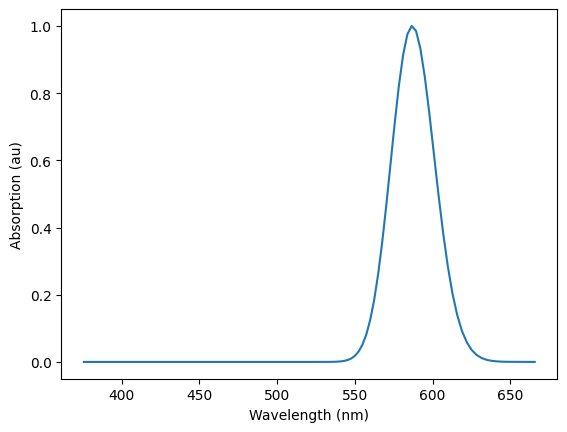

In [ ]:
from pyscf import gto, scf, dft, tddft
from pyscf.solvent import ddcosmo
from pyscf import solvent

mol = gto.Mole()
mol.atom="opt.xyz"
# set basis set
mol.basis = "6-31+G(d,p)"
mol.build()

# set DFT functional
mf = dft.RKS(mol)
mf.xc = 'B3LYP'


# initialize the mf object in gas phase
#mf.kernel()

# initialize mf object in DMSO
#mf = mf.DDCOSMO()
#mf.with_solvent.eps = 35.688  # Acetonitrile
#mf = mf.run()
mf = solvent.ddCOSMO(mf)
mf.with_solvent.eps = 46.826  # DMSO
mf.with_solvent.verbose = 4
mf.kernel()

# setup the TDDFT
td = tddft.TDDFT(mf)

# set type and number of states required
td.singlet = True
td.nstates = 10

# run TDDFT
td.kernel()

# analyze to show a table of excitations
td.analyze()

# helper function to plot absorption spectrum
def plot_absorption(td_obj, step=0.01, sigma=0.05):
    import scipy.constants as cst
    import numpy as np
    from scipy.stats import norm
    import matplotlib.pyplot as plt

    # get transitions can convert to eV
    transitions =  td_obj.e * 27.2114

    # get oscilator strengths
    f = td_obj.oscillator_strength()

    # get minimum and miximum x-values for plot
    minval = min([val for val in transitions]) - 5.0 * sigma
    #maxval = max([val for val in transitions]) + 5.0 * sigma
    maxval = 3.3

    # number of data points in line
    npts = int((maxval - minval) / step) + 1

    # generating the plot
    eneval = np.linspace(minval, maxval, npts)  # in eV
    lambdaval = [cst.h * cst.c / (val * cst.e) * 1.e9
                 for val in eneval]  # in nm

    # sum of gaussian functions
    spectra = np.zeros(npts)
    for i in range(len(transitions)):
     spectra += f[i] * norm.pdf(eneval, transitions[i], sigma)
    spectra /= spectra.max()

    # plot the spectrum
    plt.plot(lambdaval,spectra)
    plt.xlabel("Wavelength (nm)")
    plt.ylabel("Absorption (au)")

    # Find max absorption
    max_idx = np.argmax(spectra)
    max_wavelength = lambdaval[max_idx]
    max_intensity = spectra[max_idx]
    print(f"Maximum absorption at {max_wavelength:.2f} nm with intensity {max_intensity:.3f} au")

# plot the absorption from td
plot_absorption(td)


We now have a spectrum whcih shows the stroingest transitions (or absorbtion lines) and the wavelength of the light corresponding to the maximum absorbtion. We can use this wavelength now to calculate the complemeatery wavelength, which will define the color our molecule apears to our eyes. In order to do so, we need to give the variable "walwngth_nm" the corresponding value.

In [ ]:
import colorsys
import numpy as np

wavelength_nm=

def wavelength_to_rgb(wavelength_nm, gamma=0.8):
    if wavelength_nm < 380 or wavelength_nm > 780:
        return (0, 0, 0)

    if wavelength_nm < 440:
        R = -(wavelength_nm - 440) / (440 - 380)
        G = 0.0
        B = 1.0
    elif wavelength_nm < 490:
        R = 0.0
        G = (wavelength_nm - 440) / (490 - 440)
        B = 1.0
    elif wavelength_nm < 510:
        R = 0.0
        G = 1.0
        B = -(wavelength_nm - 510) / (510 - 490)
    elif wavelength_nm < 580:
        R = (wavelength_nm - 510) / (580 - 510)
        G = 1.0
        B = 0.0
    elif wavelength_nm < 645:
        R = 1.0
        G = -(wavelength_nm - 645) / (645 - 580)
        B = 0.0
    else:
        R = 1.0
        G = 0.0
        B = 0.0

    if wavelength_nm < 420:
        factor = 0.3 + 0.7 * (wavelength_nm - 380) / (420 - 380)
    elif wavelength_nm <= 700:
        factor = 1.0
    else:
        factor = 0.3 + 0.7 * (780 - wavelength_nm) / (780 - 700)

    def adjust(c):
        if c == 0.0:
            return 0
        return int(round(255 * ((c * factor) ** gamma)))

    return (adjust(R), adjust(G), adjust(B))


def rgb_to_hsv_normalized(r, g, b):
    return colorsys.rgb_to_hsv(r / 255, g / 255, b / 255)

def hsv_to_rgb_int(h, s, v):
    r, g, b = colorsys.hsv_to_rgb(h, s, v)
    return int(r * 255), int(g * 255), int(b * 255)

def find_closest_wavelength(target_rgb):
    min_dist = float('inf')
    best_wavelength = None
    for wl in range(380, 781):
        rgb = wavelength_to_rgb(wl)
        dist = np.linalg.norm(np.array(rgb) - np.array(target_rgb))
        if dist < min_dist:
            min_dist = dist
            best_wavelength = wl
    return best_wavelength

def complementary_wavelength(wavelength_nm):
    base_rgb = wavelength_to_rgb(wavelength_nm)
    hsv = rgb_to_hsv_normalized(*base_rgb)
    comp_hue = (hsv[0] + 0.5) % 1.0  # 180 degrees shift
    comp_rgb = hsv_to_rgb_int(comp_hue, hsv[1], hsv[2])
    comp_wavelength = find_closest_wavelength(comp_rgb)
    return {
        "input_wavelength": wavelength_nm,
        "input_rgb": base_rgb,
        "complementary_rgb": comp_rgb,
        "approx_complementary_wavelength": comp_wavelength
    }
result = complementary_wavelength(wavelength_nm)
print(result)

{'input_wavelength': 515, 'input_rgb': (31, 255, 0), 'complementary_rgb': (224, 0, 255), 'approx_complementary_wavelength': 410}


Now let's visualize it

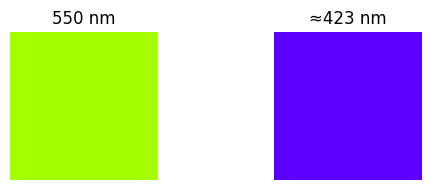

{'input_wavelength': 550, 'input_rgb': (163, 255, 0), 'complementary_rgb': (91, 0, 255), 'approx_complementary_wavelength': 423}


In [ ]:
import colorsys
import numpy as np

wavelength_nm=550


def wavelength_to_rgb(wavelength_nm, gamma=0.8):
    if wavelength_nm < 380 or wavelength_nm > 780:
        return (0, 0, 0)

    if wavelength_nm < 440:
        R = -(wavelength_nm - 440) / (440 - 380)
        G = 0.0
        B = 1.0
    elif wavelength_nm < 490:
        R = 0.0
        G = (wavelength_nm - 440) / (490 - 440)
        B = 1.0
    elif wavelength_nm < 510:
        R = 0.0
        G = 1.0
        B = -(wavelength_nm - 510) / (510 - 490)
    elif wavelength_nm < 580:
        R = (wavelength_nm - 510) / (580 - 510)
        G = 1.0
        B = 0.0
    elif wavelength_nm < 645:
        R = 1.0
        G = -(wavelength_nm - 645) / (645 - 580)
        B = 0.0
    else:
        R = 1.0
        G = 0.0
        B = 0.0

    if wavelength_nm < 420:
        factor = 0.3 + 0.7 * (wavelength_nm - 380) / (420 - 380)
    elif wavelength_nm <= 700:
        factor = 1.0
    else:
        factor = 0.3 + 0.7 * (780 - wavelength_nm) / (780 - 700)

    def adjust(c):
        if c == 0.0:
            return 0
        return int(round(255 * ((c * factor) ** gamma)))

    return (adjust(R), adjust(G), adjust(B))


def rgb_to_hsv_normalized(r, g, b):
    return colorsys.rgb_to_hsv(r / 255, g / 255, b / 255)

def hsv_to_rgb_int(h, s, v):
    r, g, b = colorsys.hsv_to_rgb(h, s, v)
    return int(r * 255), int(g * 255), int(b * 255)

def find_closest_wavelength(target_rgb):
    min_dist = float('inf')
    best_wavelength = None
    for wl in range(380, 781):
        rgb = wavelength_to_rgb(wl)
        dist = np.linalg.norm(np.array(rgb) - np.array(target_rgb))
        if dist < min_dist:
            min_dist = dist
            best_wavelength = wl
    return best_wavelength

def complementary_wavelength(wavelength_nm):
    base_rgb = wavelength_to_rgb(wavelength_nm)
    hsv = rgb_to_hsv_normalized(*base_rgb)
    comp_hue = (hsv[0] + 0.5) % 1.0  # 180 degrees shift
    comp_rgb = hsv_to_rgb_int(comp_hue, hsv[1], hsv[2])
    comp_wavelength = find_closest_wavelength(comp_rgb)
    # Plotting the original and complementary color
    fig, ax = plt.subplots(1, 2, figsize=(6, 2))
    ax[0].imshow([[np.array(base_rgb)/255]])
    ax[0].set_title(f"{wavelength_nm} nm")
    ax[0].axis("off")

    ax[1].imshow([[np.array(comp_rgb)/255]])
    ax[1].set_title(f"≈{comp_wavelength} nm")
    ax[1].axis("off")

    plt.tight_layout()
    plt.show()
    return {
        "input_wavelength": wavelength_nm,
        "input_rgb": base_rgb,
        "complementary_rgb": comp_rgb,
        "approx_complementary_wavelength": comp_wavelength
    }
result = complementary_wavelength(wavelength_nm)
print(result)